# Building Tensorflow model and convert it to TFLite model



In [0]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [0]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [0]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.0.0-beta0
Hub version:  0.5.0
Eager mode:  True
GPU is available


## Using Simple transfer learning

### Dataset preparation


In [0]:
data_root="/content/drive/My Drive/AAAAA/Mushrooms/Mushrooms"
print(data_root)

/content/drive/My Drive/AAAAA/Mushrooms/Mushrooms


In [0]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 485 images belonging to 9 classes.
Found 1951 images belonging to 9 classes.


In [0]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 9)


In [0]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Agaricus' 'Amanita' 'Boletus' 'Cortinarius' 'Entoloma' 'Hygrocybe'
 'Lactarius' 'Russula' 'Suillus']


In [0]:
for i in dataset_labels:
  print(i)

Agaricus
Amanita
Boletus
Cortinarius
Entoloma
Hygrocybe
Lactarius
Russula
Suillus


### Model architecture, training

As a base model for transfer learning, we'll use MobileNet v2 model stored on TensorFlow Hub. This model can be used only in TensorFlow 2.0 


In [0]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  11529     
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [0]:
# Run model training

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=20,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/20
61/61 [==============================] - 29s 476ms/step - loss: 0.4656 - acc: 0.8452 - val_loss: 0.7932 - val_acc: 0.7464
Epoch 2/20
61/61 [==============================] - 24s 391ms/step - loss: 0.4276 - acc: 0.8503 - val_loss: 0.8424 - val_acc: 0.7443
Epoch 3/20
61/61 [==============================] - 24s 391ms/step - loss: 0.4210 - acc: 0.8565 - val_loss: 0.7888 - val_acc: 0.7546
Epoch 4/20
61/61 [==============================] - 24s 392ms/step - loss: 0.3921 - acc: 0.8688 - val_loss: 0.7917 - val_acc: 0.7567
Epoch 5/20
61/61 [==============================] - 24s 388ms/step - loss: 0.3753 - acc: 0.8739 - val_loss: 0.8009 - val_acc: 0.7485
Epoch 6/20
61/61 [==============================] - 24s 392ms/step - loss: 0.3638 - acc: 0.8816 - val_loss: 0.7985 - val_acc: 0.7443
Epoch 7/20
61/61 [==============================] - 24s 390ms/step - loss: 0.3400 - acc: 0.8954 - val_loss: 0.8030 - val_acc: 0.7485
Epoch 8/20
61/61 [==============================] - 24s 388ms/step - 

In [0]:
# Measure accuracy and loss after training

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

16/16 [==============================] - 5s 322ms/step - loss: 0.8380 - acc: 0.7505


In [0]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

Final loss: 0.84
Final accuracy: 75.05%


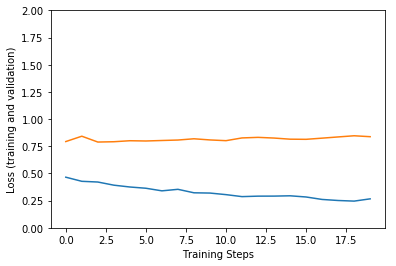

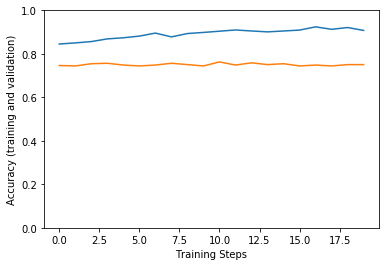

In [0]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [0]:
cd /content/drive/My Drive/AAAAA/Mushrooms

/content/drive/My Drive/AAAAA/Mushrooms


### Exporting model

We'll save our model as TensorFlow SavedModel format. After that we'll do inference on reloaded model, so if we come with a model already trained, it'll be easier to inspect it.

In [0]:
FLOWERS_SAVED_MODEL = "saved_models/flowers"
tf.keras.experimental.export_saved_model(model, FLOWERS_SAVED_MODEL)

W0810 15:31:18.879485 140259996714880 export_utils.py:182] Export includes no default signature!
W0810 15:31:19.512989 140259996714880 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0810 15:31:27.702630 140259996714880 export_utils.py:182] Export includes no default signature!
W0810 15:31:28.334111 140259996714880 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0810 15:31:35.469527 140259996714880 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'

## Load TensorFlow SavedModel

Let's load TensorFlow model from SavedModel format. Because we used custom layer from TensorFlow Hub, we need to explicitly point out the implementation with `custom_obiects` param.

In [0]:
# Load SavedModel

flowers_model = tf.keras.experimental.load_from_saved_model(FLOWERS_SAVED_MODEL, 
                                                            custom_objects={'KerasLayer':hub.KerasLayer})

Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f8f2fcf7f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7f8f1b829978>,)


### Check predictions on loaded model


In [0]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


Validation batch shape tells us that we have a batch of 32 images, with size and channels: 224x224x3.

Let's calculate predictions for the entire batch.

In [0]:
tf_model_predictions = flowers_model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 9)


In [0]:
# Convert prediction results to Pandas dataframe, for better visualization

tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Agaricus,Amanita,Boletus,Cortinarius,Entoloma,Hygrocybe,Lactarius,Russula,Suillus
0,0.00465566,0.01162138,0.33063808,0.00002546,0.00013779,0.00001902,0.65254319,0.00030189,0.00005746
1,0.01995136,0.02194197,0.00015971,0.02392846,0.02137317,0.00425012,0.20468676,0.00546145,0.69824696
2,0.00027131,0.00008056,0.82572669,0.00065794,0.00003736,0.00000133,0.04019474,0.00006690,0.13296318
3,0.00003074,0.96155900,0.00332895,0.00206661,0.00001920,0.00000945,0.03201382,0.00063328,0.00033900
4,0.00602975,0.00516685,0.07783134,0.03941783,0.00601448,0.00203353,0.38965952,0.00858782,0.46525893


In [0]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

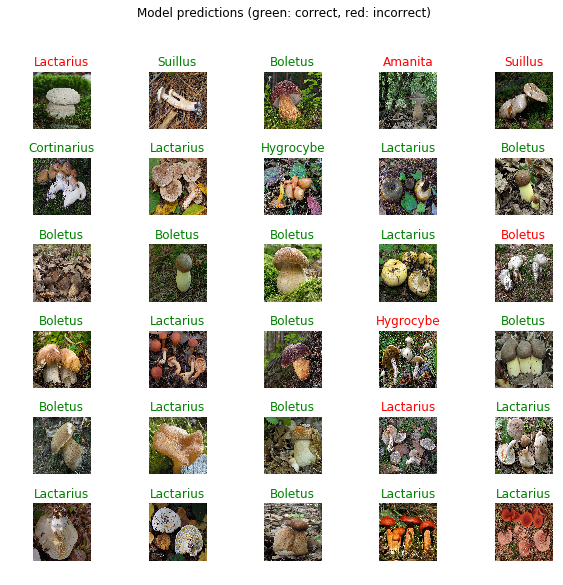

In [0]:
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## Convert model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized ).

Because of TensorFlow 2.0 nature, we'll need to convert TensorFlow model into concrete function and then do conversion to TFLite.

In [0]:
!mkdir "tflite_models"

mkdir: cannot create directory ‘tflite_models’: File exists


In [0]:
TFLITE_MODEL = "tflite_models/flowers.tflite"
TFLITE_QUANT_MODEL = "tflite_models/flowers_quant.tflite"

In [0]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : flowers_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f8f26bcffd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 244, in __del__
    .format(pretty_printer.node_names[node_id]))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/util.py", line 93, in node_names
    path_to_root[node_id] + (child.local_name,))
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/object_identity.py", line 76, in __getitem__
    return self._storage[self._wrap_key(key)]
KeyError: (<tensorflow.python.training.tracking.object_identity._ObjectIdentityWrapper object at 0x7f8f234cbbe0>,)
Exception ignored in: <bound method _CheckpointRestoreCoordinator.__del__ of <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator object at 0x7f8f20a8af9

TFLite models and their sizes:
total 11M
-rw------- 1 root root 2.3M Aug 10 15:32 flowers_quant.tflite
-rw------- 1 root root 8.6M Aug 10 15:32 flowers.tflite


### Load TFLite model

Load TensorFlow lite model with interpreter interface.

In [0]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 9]
type: <class 'numpy.float32'>


#### Resize input and output tensors shapes

Input shape of loaded TFLite model is 1x224x224x3, what means that we can make predictions for single image.

Let's resize input and output tensors, so we can make predictions for batch of 32 images.

In [0]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  9]
type: <class 'numpy.float32'>


In [0]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 9)


In [0]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = dataset_labels

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Agaricus,Amanita,Boletus,Cortinarius,Entoloma,Hygrocybe,Lactarius,Russula,Suillus
0,0.00465561,0.01162127,0.33063745,0.00002546,0.00013779,0.00001902,0.65254408,0.00030189,0.00005746
1,0.01995160,0.02194192,0.00015971,0.02392834,0.02137358,0.00425020,0.20468996,0.00546147,0.69824320
2,0.00027131,0.00008056,0.82572484,0.00065795,0.00003736,0.00000133,0.04019495,0.00006690,0.13296460
3,0.00003074,0.96155876,0.00332900,0.00206662,0.00001920,0.00000945,0.03201396,0.00063329,0.00033901
4,0.00602967,0.00516679,0.07782988,0.03941786,0.00601443,0.00203351,0.38966361,0.00858780,0.46525648


Now let's do the same for TFLite quantized model:
- Load model,
- Reshape input to handle batch of images,
- Run prediction

In [0]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)

== Input details ==
name: x
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [32  9]
type: <class 'numpy.float32'>

Prediction results shape: (32, 9)


In [0]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("Quantized TFLite model prediction results for the first elements")
tflite_q_pred_dataframe.head()

Quantized TFLite model prediction results for the first elements


,Agaricus,Amanita,Boletus,Cortinarius,Entoloma,Hygrocybe,Lactarius,Russula,Suillus
0,0.00113902,0.93272811,0.01401775,0.00003008,0.00053687,0.00000010,0.05154526,0.00000169,0.00000102
1,0.00009666,0.00995083,0.00000716,0.00365364,0.86262065,0.00039061,0.11089373,0.00000032,0.01238646
2,0.06086672,0.00003288,0.28235835,0.00017067,0.00516845,0.00000045,0.64706510,0.00000070,0.00433670
3,0.00012035,0.04121602,0.00058289,0.00062850,0.05952339,0.00006163,0.89785075,0.00000668,0.00000989
4,0.00101178,0.00143628,0.00069712,0.00748720,0.17891879,0.00304232,0.80454743,0.00174797,0.00111107


## Compare prediction results

Now we will use Pandas to visualize results from all 3 models and find differences between them.

In [0]:
# Concatenate results from all models

all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                  tflite_pred_dataframe, 
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                 axis='columns')
all_models_dataframe.head()

TF Model                          ... TFLite quantized                        
     Agaricus     Amanita     Boletus  ...        Lactarius     Russula     Suillus
0  0.00465566  0.01162138  0.33063808  ...       0.05154526  0.00000169  0.00000102
1  0.01995136  0.02194197  0.00015971  ...       0.11089373  0.00000032  0.01238646
2  0.00027131  0.00008056  0.82572669  ...       0.64706510  0.00000070  0.00433670
3  0.00003074  0.96155900  0.00332895  ...       0.89785075  0.00000668  0.00000989
4  0.00602975  0.00516685  0.07783134  ...       0.80454743  0.00174797  0.00111107

[5 rows x 27 columns]

In [0]:
# Swap columns to hava side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_pred_dataframe.columns]
all_models_dataframe.head()

Agaricus              ...     Suillus                 
     TF Model      TFLite  ...      TFLite TFLite quantized
0  0.00465566  0.00465561  ...  0.00005746       0.00000102
1  0.01995136  0.01995160  ...  0.69824320       0.01238646
2  0.00027131  0.00027131  ...  0.13296460       0.00433670
3  0.00003074  0.00003074  ...  0.00033901       0.00000989
4  0.00602975  0.00602967  ...  0.46525648       0.00111107

[5 rows x 27 columns]

In [0]:
# Highlight TFLite models predictions that are different from original model

def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

As we can see, in most cases predictions are different between all models, usually by small factors. High-confidence predictions between TensorFlow and TensorFlow Lite models are very close to each other (in some cases there are even similar).  
Quantized model outstands the most, but this is the cost of optimizations (model weights 3-4 times less).

To make prediction results even more readable, let's simplify dataframes, to show only the highest-score prediction and the corresponding label.

In [0]:
# Concatenation of argmax and max value for each row
def max_values_only(data):
  argmax_col = np.argmax(data, axis=1).reshape(-1, 1)
  max_col = np.max(data, axis=1).reshape(-1, 1)
  return np.concatenate([argmax_col, max_col], axis=1)

# Build simplified prediction tables
tf_model_pred_simplified = max_values_only(tf_model_predictions)
tflite_model_pred_simplified = max_values_only(tflite_model_predictions)
tflite_q_model_pred_simplified = max_values_only(tflite_q_model_predictions)

In [0]:
# Build DataFrames and present example
columns_names = ["Label_id", "Confidence"]
tf_model_simple_dataframe = pd.DataFrame(tf_model_pred_simplified)
tf_model_simple_dataframe.columns = columns_names

tflite_model_simple_dataframe = pd.DataFrame(tflite_model_pred_simplified)
tflite_model_simple_dataframe.columns = columns_names

tflite_q_model_simple_dataframe = pd.DataFrame(tflite_q_model_pred_simplified)
tflite_q_model_simple_dataframe.columns = columns_names

tf_model_simple_dataframe.head()

,Label_id,Confidence
0,6.0,0.65254319
1,8.0,0.69824696
2,2.0,0.82572669
3,1.0,0.96155900
4,8.0,0.46525893


In [0]:
# Concatenate results from all models
all_models_simple_dataframe = pd.concat([tf_model_simple_dataframe, 
                                         tflite_model_simple_dataframe, 
                                         tflite_q_model_simple_dataframe], 
                                        keys=['TF Model', 'TFLite', 'TFLite quantized'],
                                        axis='columns')

# Swap columns for side-by-side comparison
all_models_simple_dataframe = all_models_simple_dataframe.swaplevel(axis='columns')[tf_model_simple_dataframe.columns]

# Highlight differences
all_models_simple_dataframe.style.apply(highlight_diff, axis=None)

## Visualize predictions from TFLite models

At the end let's visualize predictions from TensorFlow Lite and quantized TensorFlow Lite models.

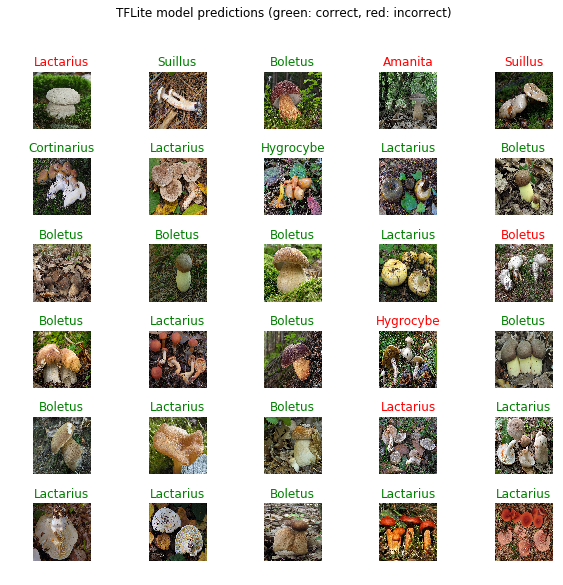

In [0]:
# Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

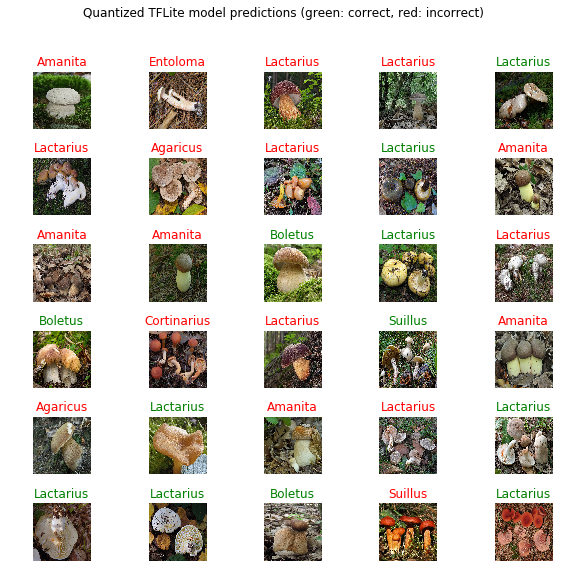

In [0]:
# Print images batch and labels predictions for TFLite Model

tflite_q_predicted_ids = np.argmax(tflite_q_model_predictions, axis=-1)
tflite_q_predicted_labels = dataset_labels[tflite_q_predicted_ids]
tflite_q_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_q_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_q_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Quantized TFLite model predictions (green: correct, red: incorrect)")

## Export image validation batch

Export validation batch so it can be tested client side. Below we create compressed file containing all images named with the convention:

`n{}_true{}_pred{}.jpg`

where the first number is index, the second - true label index, the third - value predicted by TFLite moder generated in this notebook. Example file will look similar to this: `n0_true1_pred1.jpg`.

All images then will be put into client side testing code (res/assets in Android tests). Integration tests will run inference process on each image and then compare results with the ones saved in file names.

In [0]:
from PIL import Image

In [0]:
VAL_BATCH_DIR = "validation_batch"

In [0]:
!mkdir {VAL_BATCH_DIR}

mkdir: cannot create directory ‘validation_batch’: File exists


In [0]:
# Export batch to *.jpg files with specific naming convention.
# Make sure they are exported in the full quality, otherwise the inference
# process will return different results. 

for n in range(32):
  filename = "n{:0.0f}_true{:0.0f}_pred{:0.0f}.jpg".format(
      n,
      true_label_ids[n],
      tflite_model_pred_simplified[n][0]
  )
  img_arr = np.copy(val_image_batch[n])
  img_arr *= 255
  img_arr = img_arr.astype("uint8")
  img11 = Image.fromarray(img_arr, 'RGB')
  img11.save("{}/{}".format(VAL_BATCH_DIR, filename), "JPEG", quality=100)

In [0]:
!tar -zcvf {VAL_BATCH_DIR}.tar.gz {VAL_BATCH_DIR}

validation_batch/
validation_batch/n0_true6_pred6.jpg
validation_batch/n1_true8_pred8.jpg
validation_batch/n2_true6_pred6.jpg
validation_batch/n3_true6_pred6.jpg
validation_batch/n4_true2_pred2.jpg
validation_batch/n5_true2_pred2.jpg
validation_batch/n6_true6_pred6.jpg
validation_batch/n7_true6_pred6.jpg
validation_batch/n8_true2_pred6.jpg
validation_batch/n9_true2_pred2.jpg
validation_batch/n10_true8_pred8.jpg
validation_batch/n11_true2_pred2.jpg
validation_batch/n12_true6_pred2.jpg
validation_batch/n13_true2_pred2.jpg
validation_batch/n14_true5_pred5.jpg
validation_batch/n15_true2_pred2.jpg
validation_batch/n16_true5_pred5.jpg
validation_batch/n17_true8_pred8.jpg
validation_batch/n18_true8_pred8.jpg
validation_batch/n19_true2_pred2.jpg
validation_batch/n20_true6_pred6.jpg
validation_batch/n21_true6_pred2.jpg
validation_batch/n22_true2_pred2.jpg
validation_batch/n23_true4_pred5.jpg
validation_batch/n24_true5_pred5.jpg
validation_batch/n25_true6_pred6.jpg
validation_batch/n26_true1_pre

File `validation_batch.tar.gz` is ready to be downloaded, unpacked and put into client-side testing code.